In [142]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
%matplotlib inline

In [143]:
def noiseReductionUsingGaussian(image) :
    blur = cv2.GaussianBlur(image,(5,5),0)
    return blur

(225, 225)


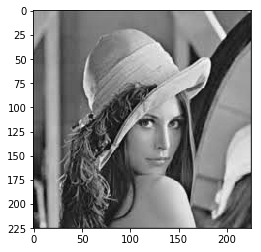

In [161]:
image = cv2.imread("/home/guru/Desktop/ComputerVision/Assignment1/IpythonNotebooks/Edge2.jpeg",0)
print(image.shape)
plt.imshow(image,cmap = "gray")

In [162]:
image

array([[116, 142, 138, ..., 133, 147, 109],
       [138, 163, 159, ..., 165, 182, 124],
       [133, 158, 154, ..., 130, 131,  82],
       ..., 
       [ 49,  48,  47, ...,  75,  81,  79],
       [ 49,  47,  46, ...,  81,  89,  80],
       [ 30,  45,  39, ...,  81,  86,  75]], dtype=uint8)

In [163]:
blur = noiseReductionUsingGaussian(image)

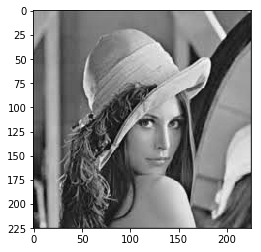

In [164]:
plt.imshow(image,cmap = "gray")

In [165]:
def round_angle(angle) :
    #Converting angle from radians to degrees
    angle = np.rad2deg(angle) % 180
   # print(angle)
    
    #Rounding to horizontal direction
    if (0 <= angle < 22.5) or (157.5 <= angle < 180):
        angle = 0
        
    #Rounding to diagonal direction
    elif(22.5 <= angle < 67.5):
        angle = 45
        
    #Rounding to vertical direction
    elif(67.5 <= angle < 112.5):
        angle = 90
    
    #Rounding to diagonal direction
    else :
        angle = 135
        
    return angle

In [166]:
def intensity_gradient(image) :
    #Finding Gradient using sobel operator
    #Kernel in X direction
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.int32)
    
    #Kernel in Y direction
    Ky = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.int32)
    
    #Applying Kernels to the image
    Ix = ndimage.filters.convolve(image,Kx)
    Iy = ndimage.filters.convolve(image,Ky)
    
    #Calculating the gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    D = np.arctan2(Iy, Ix)
    
    #Calculating the Directions by rounding off
    M, N = D.shape
    R_D = np.zeros((M,N), dtype = np.int32)
    
    #print(D.shape)
    #print(D[0][0])
    for i in range(M) :
        for j in range(N) :
            R_D[i][j] = round_angle(D[i,j])
    
    return (G,R_D)

In [167]:
gradient, direction = intensity_gradient(blur)

In [168]:
np.max(gradient)

360.5

In [169]:
direction

array([[45, 45, 45, ..., 45, 45, 45],
       [45, 45, 45, ..., 45, 45, 45],
       [45, 45, 45, ..., 45, 45, 45],
       ..., 
       [ 0, 45, 45, ..., 45, 45, 45],
       [45, 45, 45, ..., 45, 45, 45],
       [45, 45, 45, ..., 45, 45, 45]], dtype=int32)

In [170]:
def non_max_supression(gradient, direction) :
    
    M, N = gradient.shape
    S = np.zeros((M,N), dtype = np.int32)
    #Todo : Dealing in a better way with boundary points
    for i in range(M):
        for j in range(N):
            if(direction[i][j] == 0) :
                if((j!= 0 and j!= N-1) and (gradient[i, j] >= gradient[i, j - 1]) and (gradient[i, j] >= gradient[i, j + 1])):
                    S[i,j] = gradient[i,j]
                    
            elif(direction[i][j] == 90) :
                if ((i!=0 and i!= M-1) and (gradient[i, j] >= gradient[i - 1, j]) and (gradient[i, j] >= gradient[i + 1, j])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 45) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and (gradient[i, j] >= gradient[i - 1, j + 1]) and (gradient[i, j] >= gradient[i + 1, j - 1])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 135) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and gradient[i, j] >= gradient[i - 1, j - 1]) and (gradient[i, j] >= gradient[i + 1, j + 1]):
                    S[i,j] = gradient[i,j]
    
    return S
    

In [171]:
S = non_max_supression(gradient, direction)

In [172]:
S

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 332,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   0, 336,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [173]:
def hysteresisThresholding(gradient, minVal,maxVal) :
    sure_edge_i, sure_edge_j = np.where(gradient > maxVal)
    doubt_i, doubt_j = np.where((gradient >= minVal) & (gradient <= maxVal))
    non_edge_i, non_edge_j = np.where(gradient < minVal)
    
    gradient[sure_edge_i, sure_edge_j] = np.int(255)
    gradient[doubt_i, doubt_j] = np.int(128)
    gradient[non_edge_i, non_edge_j] = np.int(0)
    
    
    M,N = gradient.shape
    
    for i in range(1,M-1) :
        for j in range(1,N-1) :
            if(gradient[i][j] == 128) :
                if ((gradient[i + 1, j] == 255) or (gradient[i - 1, j] == 128)
                         or (gradient[i, j + 1] == 255) or (gradient[i, j - 1] == 255)
                         or (gradient[i+1, j + 1] == 255) or (gradient[i-1, j - 1] == 255)):
                    gradient[i][j] = np.int(255)
                else :
                    gradient[i][j] = np.int(0)
    return gradient.astype(int)

In [174]:
image = hysteresisThresholding(gradient,150,275)

In [175]:
image

array([[255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ..., 
       [  0, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

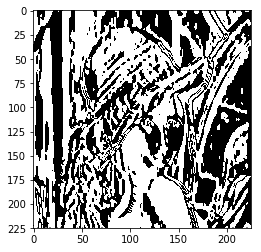

In [176]:
plt.imshow(image,cmap = "gray")